In [1]:
# Set seed for reproducibility
from numpy.random import seed
seed(1)
from tensorflow.random import set_seed
set_seed(1)

In [2]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from matplotlib import animation

from math import ceil

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, LogisticRegression

from keras import Input, Model
from keras.layers import Dense, LSTM, Masking
from keras import backend as K

import tensorflow as tf

## Data preparation

In [3]:
data = pd.read_csv('/kaggle/input/t20i-matches/t20i_matches_v4.csv')
data

,match_id,innings,target,score,wickets_in_hand,curr_rate,runs_required,balls_left,req_rate,winner,rem_run_rate
0,211048,1,-1,0,10,-1.000000,-1,120,-1.000000,0,1.783333
1,211048,1,-1,2,10,12.000000,-1,119,-1.000000,0,1.781513
2,211048,1,-1,2,10,6.000000,-1,118,-1.000000,0,1.796610
3,211048,1,-1,3,10,6.000000,-1,117,-1.000000,0,1.803419
4,211048,1,-1,4,10,6.000000,-1,116,-1.000000,0,1.810345
...,...,...,...,...,...,...,...,...,...,...,...
199391,1310942,2,128,93,2,5.072727,35,10,21.000000,0,0.200000
199392,1310942,2,128,94,2,5.081081,34,9,22.666667,0,0.111111
199393,1310942,2,128,95,2,5.089286,33,8,24.750000,0,0.000000
199394,1310942,2,128,95,2,5.044248,33,7,28.285714,0,0.000000


In [4]:
mask_value = -1
data.replace(-1, mask_value, inplace = True)

In [5]:
max_time_steps = data.groupby('match_id').apply(lambda x: x.shape[0]).max()

def pad_rows(match):
    time_steps = match.shape[0]
    diff = max_time_steps - time_steps
    mask = [mask_value] * (data.shape[1] - 2)
    mask.append(match.winner.iloc[0])
    mask.append(0)
    padding = pd.DataFrame([mask] * diff, columns = data.columns)
    return pd.concat([match, padding], ignore_index = True)

data = data.groupby('match_id', sort = False).apply(pad_rows).reset_index(drop = True)

In [6]:
X, y = data.iloc[:, 1:-2], data.iloc[:, -2:]
input_features = X

In [7]:
def format_input_output(raw_X, raw_y, is_for_lstm = False):
    X = raw_X.copy()
    y = raw_y.copy()
    
    if(is_for_lstm):
        X = X.values.reshape((-1, max_time_steps, input_features.shape[1])).astype('float32')
        y1 = y.iloc[:, 0].values.reshape((-1, max_time_steps, 1)).astype('float32')
        y2 = y.iloc[:, -1].values.reshape((-1, max_time_steps, 1)).astype('float32')
    else:
        y = y[X.innings != mask_value].reset_index(drop = True)
        X = X[X.innings != mask_value].reset_index(drop = True)
        y1 = y.iloc[:, 0]
        y2 = y.iloc[:, -1]
        
    return (X, y1, y2)

In [8]:
def prep_data(test_split = 0.2, is_val_needed = True, val_split = 0.2, is_for_lstm = False):
    num_matches = data.match_id.nunique()
    num_test_matches = ceil(test_split * num_matches)
    
    test_size = num_test_matches * max_time_steps
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = test_size, shuffle = False)
    
    if (is_val_needed):
        num_val_matches = ceil(val_split * (num_matches - num_test_matches))
        val_size = num_val_matches * max_time_steps

        X_val = X_train[-val_size:].reset_index(drop = True)
        y_val = y_train[-val_size:].reset_index(drop = True)

        X_train = X_train[:-val_size]
        y_train = y_train[:-val_size]

    X_test = X_test.reset_index(drop = True)
    y_test = y_test.reset_index(drop = True)
    
    X_train, y1_train, y2_train = format_input_output(X_train, y_train, is_for_lstm = is_for_lstm)

    if(is_val_needed):
        X_val, y1_val, y2_val = format_input_output(X_val, y_val, is_for_lstm = is_for_lstm)

    X_test, y1_test, y2_test = format_input_output(X_test, y_test, is_for_lstm = is_for_lstm)
        
    if (is_val_needed):
        return (X_train, X_val, X_test, y1_train, y2_train, y1_val, y2_val, y1_test, y2_test, val_size, test_size)
    else:
        return (X_train, X_test, y1_train, y2_train, y1_test, y2_test, test_size)

In [9]:
X_train, X_val, X_test, y1_train, y2_train, y1_val, y2_val, y1_test, y2_test, val_size, test_size = prep_data(is_for_lstm = True)

## Model training and evaluation

In [10]:
def rmse(y_true, y_pred):
    return K.abs(K.sqrt(tf.keras.losses.MSE(y_true, y_pred)))

In [11]:
def rectify_scores(results, win_prob_feature = 'pred_winner', score_feature = 'pred_score'):
    temp = results.copy()
    
    incorrect_pred = temp[(temp.innings == 2) & (temp[win_prob_feature] < 0.5) & (temp[score_feature] >= temp.target)]
    temp.loc[incorrect_pred.index, score_feature] = incorrect_pred.target - 2
    
    incorrect_pred = temp[(temp.innings == 2) & (temp[win_prob_feature] == 0.5)]
    temp.loc[incorrect_pred.index, score_feature] = incorrect_pred.target - 1
    
    incorrect_pred = temp[(temp.innings == 2) & (temp[win_prob_feature] > 0.5)]
    temp.loc[incorrect_pred.index, score_feature] = incorrect_pred.target
    
    return temp

In [12]:
def compile_results(X, y1, y2, model, is_for_lstm = False, scaler = None, win_prob_feature = 'pred_winner', score_feature = 'pred_rem_run_rate', is_final_model = False):
    if (is_for_lstm):
        results = pd.DataFrame(X.reshape(-1, input_features.shape[1]), columns = input_features.columns)
        y_pred = model.predict(X)
        
        results[win_prob_feature] = y_pred[0].reshape(-1)
        results['actual_winner'] = y1.reshape(-1)
        results[score_feature] = y_pred[1].reshape(-1)
        results['actual_rem_run_rate'] = y2.reshape(-1)
    else:
        results = X.copy()
        X_scaled = np.nan_to_num(scaler.transform(X[X != mask_value]), nan = mask_value)
        
        results[win_prob_feature] = model[0].predict_proba(X_scaled)[:, 1]
        results['actual_winner'] = y1
        results[score_feature] = model[1].predict(X_scaled)
        results['actual_rem_run_rate'] = y2
    
    results = results[results.innings != mask_value].reset_index(drop = True)

    if (not is_final_model):
        results['pred_score'] = results.pred_rem_run_rate * results.balls_left + results.score
        results['actual_score'] = results.actual_rem_run_rate * results.balls_left + results.score
        results = rectify_scores(results)
    
    return results

In [13]:
def build_lstm(memory_units = 32, num_lstm = 1, train = True, learning_rate = 1e-3, num_epochs = 150, batch_size = 32, patience = 5):
    K.clear_session()
    set_seed(1)
    
    inputs = Input(shape = (max_time_steps, input_features.shape[1]))

    x = Masking(mask_value = mask_value)(inputs)
    lstm = LSTM(memory_units, return_sequences = True)(x)
    
    for i in range(num_lstm - 1):
        lstm = LSTM(memory_units, return_sequences = True)(lstm)
    
    output1 = Dense(1, activation = 'sigmoid', name = 'winner')(lstm)
    output2 = Dense(1, name = 'score')(lstm)
    
    model = Model(inputs, [output1, output2])
    model.compile(
        loss = {
            'winner': 'binary_crossentropy',
            'score': rmse
        },
        optimizer = tf.keras.optimizers.Adam(learning_rate = learning_rate)
    )
    
    if (train):
        print(model.summary())
        
        early_stopping_monitor = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', patience = patience, restore_best_weights = True)
        history = model.fit(X_train, [y1_train, y2_train], epochs = num_epochs, batch_size = batch_size, 
                            validation_data = (X_val, [y1_val, y2_val]), callbacks = [early_stopping_monitor])

        plt.plot(history.history['winner_loss'])
        plt.plot(history.history['val_winner_loss'])
        plt.ylabel('Classification Loss')
        plt.xlabel('Epoch')
        plt.legend(['train', 'val'])
        plt.show()

        plt.plot(history.history['score_loss'])
        plt.plot(history.history['val_score_loss'])
        plt.ylabel('Regression Loss')
        plt.xlabel('Epoch')
        plt.legend(['train', 'val'])
        plt.show()

        early_stopped_epochs = early_stopping_monitor.stopped_epoch + 1
        patience = early_stopping_monitor.patience
        final_model_epochs = early_stopped_epochs - patience

        val = compile_results(X_val, y1_val, y2_val, model, is_for_lstm = True)
        test = compile_results(X_test, y1_test, y2_test, model, is_for_lstm = True)

        return (val, test, model, final_model_epochs)
    else:
        return model

2022-10-13 00:51:58.186187: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-13 00:51:58.199667: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-13 00:51:58.200854: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-13 00:51:58.202808: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 262, 8)]     0                                            
__________________________________________________________________________________________________
masking (Masking)               (None, 262, 8)       0           input_1[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM)                     (None, 262, 64)      18688       masking[0][0]                    
__________________________________________________________________________________________________
winner (Dense)                  (None, 262, 1)       65          lstm[0][0]                       
______________________________________________________________________________________________

2022-10-13 00:52:01.300965: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2022-10-13 00:52:05.693417: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


5/5 [==============================] - 6s 321ms/step - loss: 1.7181 - winner_loss: 0.6782 - score_loss: 1.0400 - val_loss: 1.4346 - val_winner_loss: 0.6692 - val_score_loss: 0.7654
Epoch 2/150
5/5 [==============================] - 0s 29ms/step - loss: 1.2935 - winner_loss: 0.6493 - score_loss: 0.6442 - val_loss: 1.1646 - val_winner_loss: 0.6350 - val_score_loss: 0.5296
Epoch 3/150
5/5 [==============================] - 0s 30ms/step - loss: 1.0533 - winner_loss: 0.6186 - score_loss: 0.4347 - val_loss: 0.9717 - val_winner_loss: 0.6146 - val_score_loss: 0.3571
Epoch 4/150
5/5 [==============================] - 0s 27ms/step - loss: 0.9475 - winner_loss: 0.6027 - score_loss: 0.3448 - val_loss: 0.9542 - val_winner_loss: 0.6003 - val_score_loss: 0.3539
Epoch 5/150
5/5 [==============================] - 0s 29ms/step - loss: 0.9458 - winner_loss: 0.5876 - score_loss: 0.3582 - val_loss: 0.9232 - val_winner_loss: 0.5845 - val_score_loss: 0.3387
Epoch 6/150
5/5 [==============================] - 

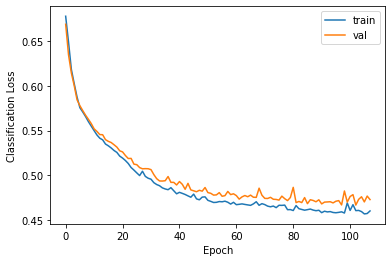

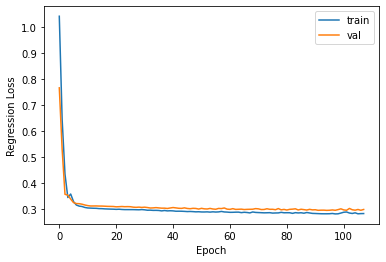

In [14]:
val_lstm, test_lstm, lstm, final_lstm_epochs = build_lstm(memory_units = 64, batch_size = 128, patience = 10)

## Comparing LSTM with linear ML models

In [15]:
x_ticks = list(range(41))
x_tick_labels = list(map(str, list(range(21)) + list(range(1, 21))))
innings_break_pt = 20

method_colors = {
    'Logistic Regression': 'C0',
    'Linear Regression': 'C0',
    'LSTM': 'C1',
    'Meta': 'C2'
}

In [16]:
def fill_plot_gaps(x, y, method_names):
    for i in range(y.shape[0] - 1):
        x1 = x.iloc[i]
        x2 = x.iloc[i + 1]
        y1 = y.iloc[i]
        y2 = y.iloc[i + 1]
        intermediate = x1 + (((-y1) * (x2 - x1)) / (y2 - y1))
        
        if (y.iloc[i] < 0 and y.iloc[i + 1] > 0):
            plt.plot([x1, intermediate], [y1, 0], c = method_colors[method_names[0]])
            plt.plot([intermediate, x2], [0, y2], c = method_colors[method_names[1]])
        elif (y.iloc[i] > 0 and y.iloc[i + 1] < 0):
            plt.plot([x1, intermediate], [y1, 0], c = method_colors[method_names[1]])
            plt.plot([intermediate, x2], [0, y2], c = method_colors[method_names[0]])

In [17]:
def compare_error_plots(method_evals, method_names, error_measure):
    overs = (method_evals[0].innings * 120 - method_evals[0].balls_left) / 6
    figsize = (12, 8)

    plt.figure(figsize = figsize)
    plt.rcParams.update({
        'axes.xmargin': 0
    })

    for method_eval in method_evals:
        plt.plot(overs, method_eval.error)

    plt.legend(method_names)
    
    plt.gca().set_xticks(x_ticks)
    plt.gca().set_xticklabels(x_tick_labels)

    plt.xlabel('Overs')
    plt.ylabel('Average Prediction Error (' + error_measure + ')')

    plt.axvline(innings_break_pt, ls = '--', c = 'grey')

    plt.show()
    
    for i in range(len(method_evals) - 1):
        for j in range(i + 1, len(method_evals)):
            plt.figure(figsize = figsize)
            plt.rcParams.update({
                'axes.xmargin': 0
            })

            error_diff = method_evals[i].error - method_evals[j].error

            plt.plot(overs, np.where(error_diff < 0, error_diff, np.nan), c = method_colors[method_names[i]])
            plt.plot(overs, np.where(error_diff > 0, error_diff, np.nan), c = method_colors[method_names[j]])
            fill_plot_gaps(overs, error_diff, [method_names[i], method_names[j]])

            plt.legend([method_names[i] + ' performs better', method_names[j] + ' performs better'])

            plt.gca().set_xticks(x_ticks)
            plt.gca().set_xticklabels(x_tick_labels)

            plt.xlabel('Overs')
            plt.ylabel('Average Prediction Error Diff (' + error_measure + ')')

            plt.axhline(0, ls = '--', c = 'grey')
            plt.axvline(innings_break_pt, ls = '--', c = 'grey')

            plt.show()

In [18]:
def compute_avg_error(results, pred_feature):
    method_eval = results.groupby(['innings', 'balls_left'], sort = False)
    
    if ('winner' in pred_feature):
        agg_func = lambda x: (100 * abs(x.actual_winner - x[pred_feature])).mean()
    else:
        agg_func = lambda x: abs(x.actual_score - x[pred_feature]).mean()
   
    method_eval = method_eval.apply(agg_func).reset_index(name = 'error')
    method_eval.sort_values(['innings', 'balls_left'], ascending = [True, False], inplace = True)
    
    return method_eval

In [19]:
def compare_reg_lstm():
    X_train, X_val, X_test, y1_train, y2_train, y1_val, y2_val, y1_test, y2_test, val_size, test_size = prep_data()
    
    scaler = StandardScaler()
    scaler.fit(X_train[X_train != mask_value])
    
    X_train = np.nan_to_num(scaler.transform(X_train[X_train != mask_value]), nan = mask_value)
    y1_train = y1_train.astype('int32').values.flatten()
    
    log_reg = LogisticRegression()
    log_reg.fit(X_train, y1_train)
    
    lin_reg = LinearRegression()
    lin_reg.fit(X_train, y2_train)
    
    val = compile_results(X_val, y1_val, y2_val, [log_reg, lin_reg], scaler = scaler)
    test = compile_results(X_test, y1_test, y2_test, [log_reg, lin_reg], scaler = scaler)
    
    winner_reg = compute_avg_error(test, 'pred_winner')
    winner_lstm = compute_avg_error(test_lstm, 'pred_winner')
        
    print('Win Prediction:')
    print('---------------')
    compare_error_plots([winner_reg, winner_lstm], ['Logistic Regression', 'LSTM'], '%')
    
    score_reg = compute_avg_error(test, 'pred_score')
    score_lstm = compute_avg_error(test_lstm, 'pred_score')
        
    print('\nScore Prediction:')
    print('-----------------')
    compare_error_plots([score_reg, score_lstm], ['Linear Regression', 'LSTM'], 'Runs')
    
    return (val, test)

Win Prediction:
---------------


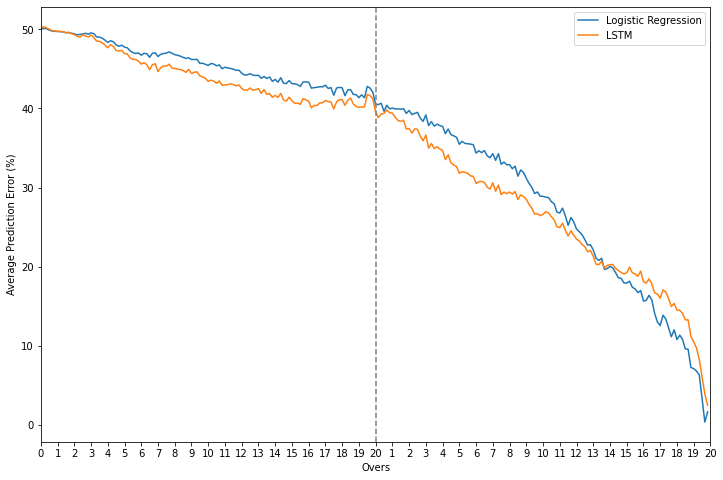

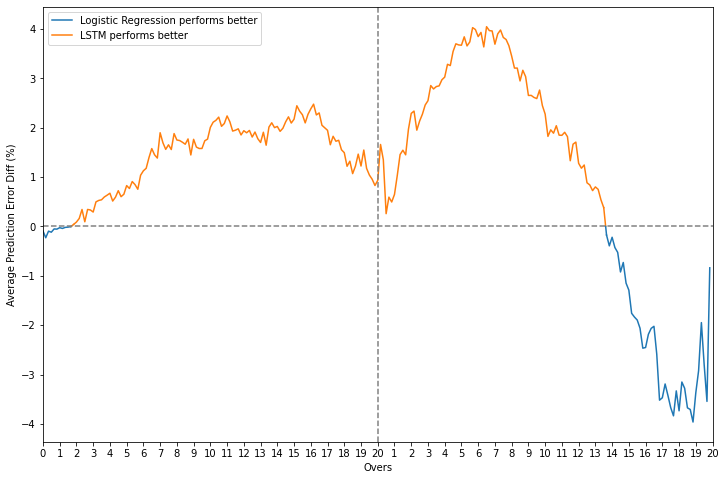


Score Prediction:
-----------------


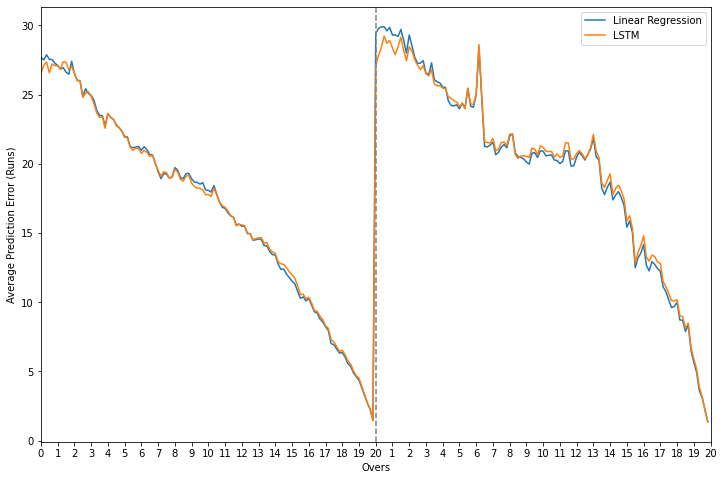

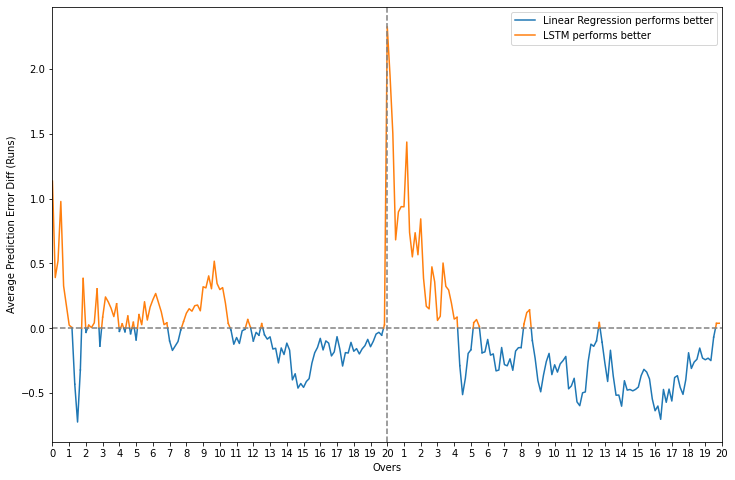

In [20]:
val_reg, test_reg = compare_reg_lstm()

## Ensembling base learners by stacking

In [21]:
def build_ensemble():
    # Fit meta-learners on val
    meta = pd.DataFrame()
    
    meta['log_reg_pred_winner'] = val_reg['pred_winner']
    meta['lstm_pred_winner'] = val_lstm['pred_winner']
    meta['lin_reg_pred_rem_run_rate'] = val_reg['pred_rem_run_rate']
    meta['lstm_pred_rem_run_rate'] = val_lstm['pred_rem_run_rate']
    
    meta[['actual_winner', 'actual_rem_run_rate']] = val_lstm[['actual_winner', 'actual_rem_run_rate']]
    
    meta = pd.concat([val_lstm.iloc[:, :input_features.shape[1]], meta], axis = 1)
    meta_X = meta.iloc[:, :-2]
    
    scaler = StandardScaler()
    scaler.fit(meta_X[meta_X != mask_value])
    meta_X = np.nan_to_num(scaler.transform(meta_X[meta_X != mask_value]), nan = mask_value)
    
    meta_y = meta.iloc[:, -2]
    
    meta_log_reg = LogisticRegression()
    meta_log_reg.fit(meta_X, meta_y)

    meta_y = meta.iloc[:, -1]
    
    meta_lin_reg = LinearRegression()
    meta_lin_reg.fit(meta_X, meta_y)
    
    # Predict on test
    meta = pd.DataFrame()
    
    meta['log_reg_pred_winner'] = test_reg['pred_winner']
    meta['lstm_pred_winner'] = test_lstm['pred_winner']
    meta['lin_reg_pred_rem_run_rate'] = test_reg['pred_rem_run_rate']
    meta['lstm_pred_rem_run_rate'] = test_lstm['pred_rem_run_rate']
    
    meta = pd.concat([test_lstm.iloc[:, :input_features.shape[1]], meta], axis = 1)
    meta_X = np.nan_to_num(scaler.transform(meta[meta != mask_value]), nan = mask_value)
    
    meta['pred_winner'] = meta_log_reg.predict_proba(meta_X)[:, 1]
    meta['pred_rem_run_rate'] = meta_lin_reg.predict(meta_X)
    meta[['actual_winner', 'actual_rem_run_rate']] = test_lstm[['actual_winner', 'actual_rem_run_rate']]
    
    winner_reg = compute_avg_error(meta, 'log_reg_pred_winner')
    winner_lstm = compute_avg_error(meta, 'lstm_pred_winner')
    winner_meta = compute_avg_error(meta, 'pred_winner')
        
    print('Win Prediction:')
    print('---------------')
    compare_error_plots([winner_reg, winner_lstm, winner_meta], ['Logistic Regression', 'LSTM', 'Meta'], '%')
    
    meta['lin_reg_pred_score'] = meta.lin_reg_pred_rem_run_rate * meta.balls_left + meta.score
    meta['lstm_pred_score'] = meta.lstm_pred_rem_run_rate * meta.balls_left + meta.score
    meta['pred_score'] = meta.pred_rem_run_rate * meta.balls_left + meta.score
    meta['actual_score'] = meta.actual_rem_run_rate * meta.balls_left + meta.score
    
    meta = rectify_scores(meta, win_prob_feature = 'log_reg_pred_winner', score_feature = 'lin_reg_pred_score')
    meta = rectify_scores(meta, win_prob_feature = 'lstm_pred_winner', score_feature = 'lstm_pred_score')
    meta = rectify_scores(meta)
    
    score_reg = compute_avg_error(meta, 'lin_reg_pred_score')
    score_lstm = compute_avg_error(meta, 'lstm_pred_score')
    score_meta = compute_avg_error(meta, 'pred_score')
        
    print('\nScore Prediction:')
    print('-----------------')
    compare_error_plots([score_reg, score_lstm, score_meta], ['Linear Regression', 'LSTM', 'Meta'], 'Runs')
    
    return meta

Win Prediction:
---------------


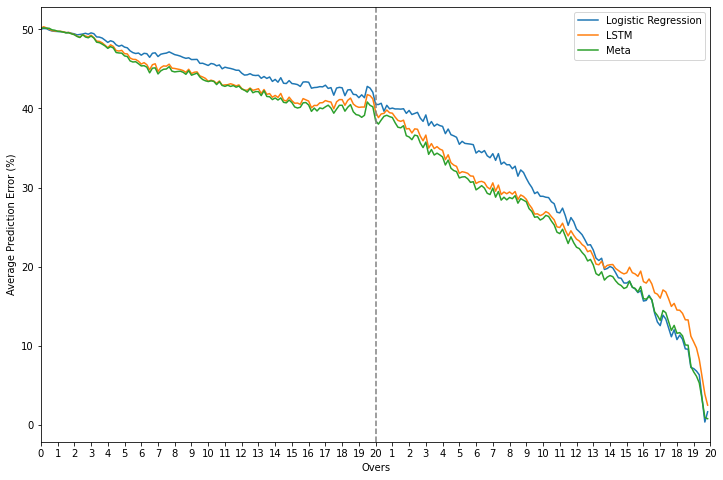

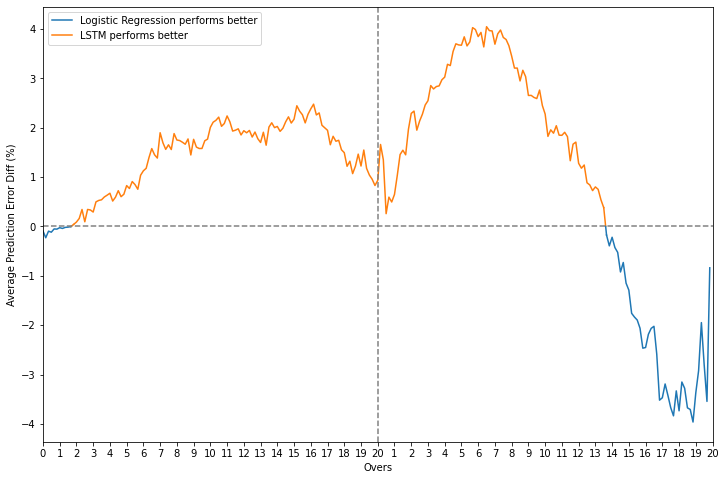

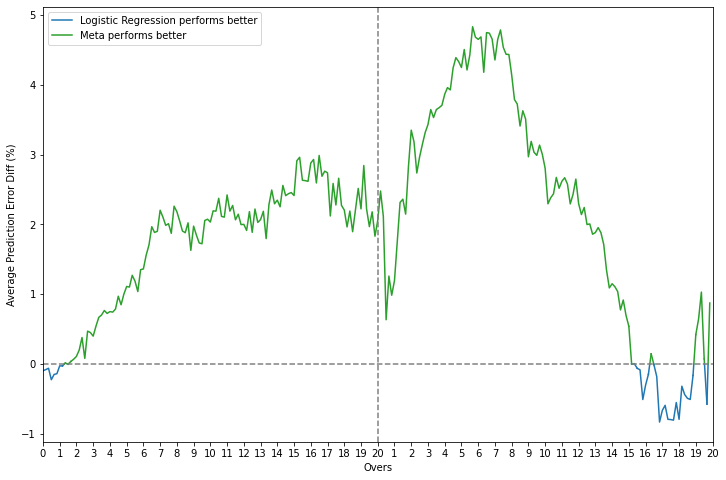

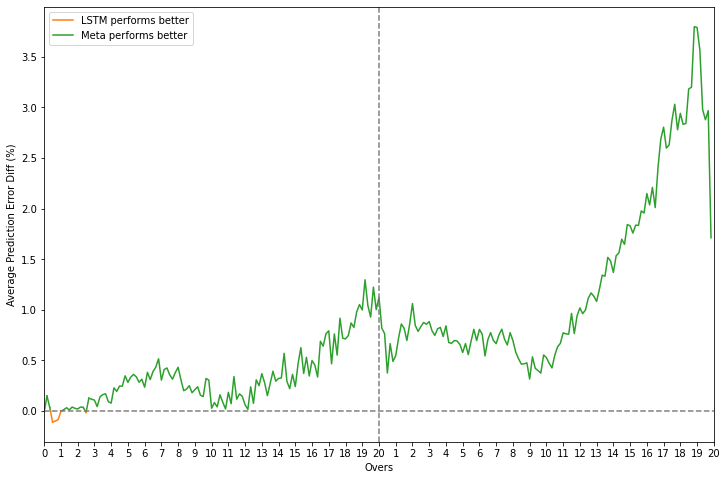


Score Prediction:
-----------------


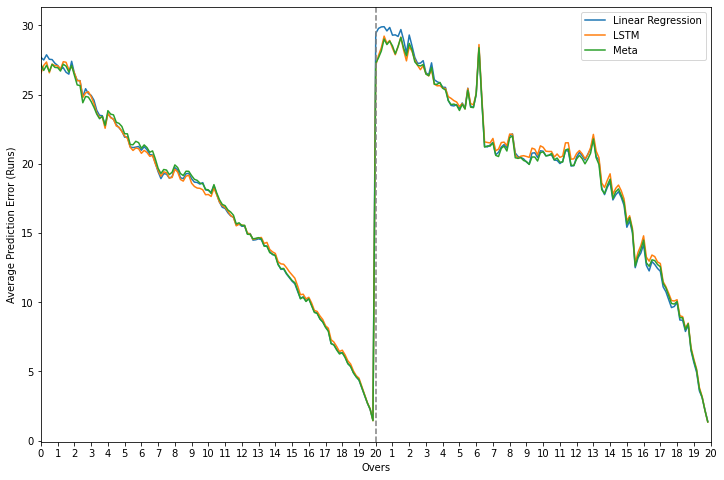

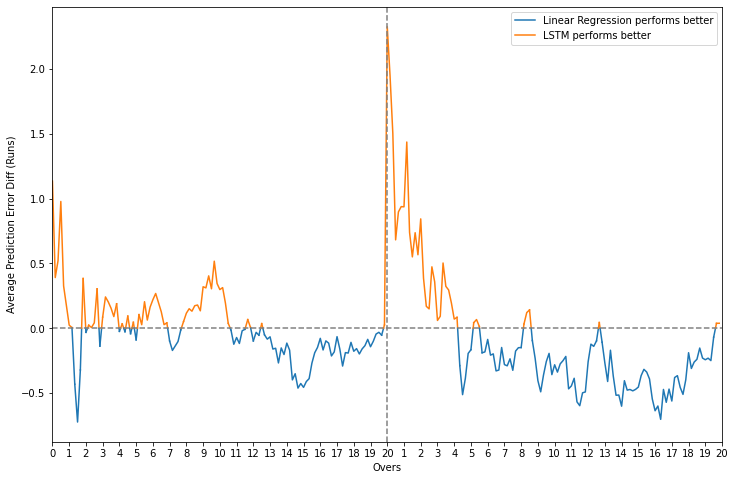

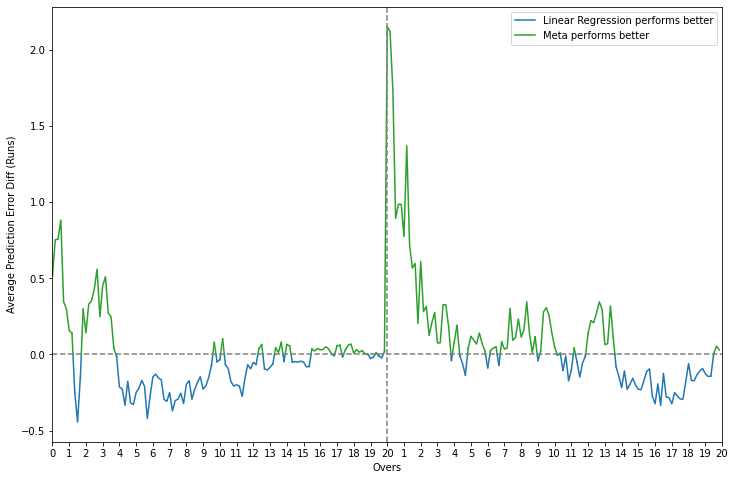

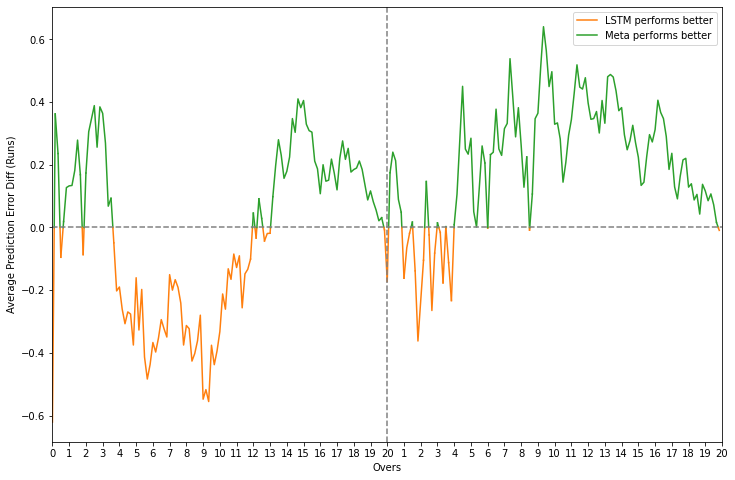

In [22]:
meta = build_ensemble()

In [23]:
meta

,innings,target,score,wickets_in_hand,curr_rate,runs_required,balls_left,req_rate,log_reg_pred_winner,lstm_pred_winner,lin_reg_pred_rem_run_rate,lstm_pred_rem_run_rate,pred_winner,pred_rem_run_rate,actual_winner,actual_rem_run_rate,lin_reg_pred_score,lstm_pred_score,pred_score,actual_score
0,1.0,-1.0,0.0,10.0,-1.000000,-1.0,120.0,-1.000000,4.953226e-01,0.476457,1.217802,1.306559,0.474995,1.350944,1.0,1.308333,146.136262,156.787094,162.113310,157.0
1,1.0,-1.0,0.0,10.0,0.000000,-1.0,119.0,-1.000000,5.066467e-01,0.497390,1.217348,1.355537,0.474548,1.359074,1.0,1.319328,144.864392,161.308853,161.729755,157.0
2,1.0,-1.0,0.0,10.0,0.000000,-1.0,118.0,-1.000000,5.124576e-01,0.516443,1.221341,1.342239,0.501955,1.357776,1.0,1.330508,144.118243,158.384155,160.217541,157.0
3,1.0,-1.0,0.0,9.0,0.000000,-1.0,117.0,-1.000000,5.495964e-01,0.554726,1.121570,1.276417,0.530773,1.251002,1.0,1.341880,131.223694,149.340759,146.367244,157.0
4,1.0,-1.0,0.0,9.0,0.000000,-1.0,116.0,-1.000000,5.553455e-01,0.574098,1.125563,1.259330,0.558370,1.247172,1.0,1.353448,130.565336,146.082291,144.671922,157.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40163,2.0,128.0,93.0,2.0,5.072727,35.0,10.0,21.000000,2.165286e-05,0.049366,1.056160,0.964272,0.001455,1.022056,0.0,0.200000,103.561597,102.642723,103.220555,95.0
40164,2.0,128.0,94.0,2.0,5.081081,34.0,9.0,22.666666,4.342829e-06,0.043134,1.061545,0.994416,0.000678,1.045892,0.0,0.111111,103.553909,102.949745,103.413031,95.0
40165,2.0,128.0,95.0,2.0,5.089286,33.0,8.0,24.750000,5.801181e-07,0.037227,1.066406,1.025401,0.000262,1.070533,0.0,0.000000,103.531247,103.203209,103.564266,95.0
40166,2.0,128.0,95.0,2.0,5.044248,33.0,7.0,28.285715,1.887587e-08,0.032003,1.065901,1.027410,0.000054,1.075626,0.0,0.000000,102.461309,102.191872,102.529381,95.0


## Model testing

In [24]:
def prep_final_data(is_for_lstm = False):
    return format_input_output(X, y, is_for_lstm = is_for_lstm)

In [25]:
def build_final_models(num_epochs):
    lstm = build_lstm(memory_units = 64, train = False)    
    X, y1, y2 = prep_final_data(is_for_lstm = True)
    
    history = lstm.fit(X, [y1, y2], epochs = num_epochs, batch_size = 128, verbose = 0)
    final_results = compile_results(X, y1, y2, lstm, is_for_lstm = True, win_prob_feature = 'lstm_pred_winner', 
                                    score_feature = 'lstm_pred_rem_run_rate', is_final_model = True)
    
    X, y1, y2 = prep_final_data()
    
    base_scaler = StandardScaler()
    base_scaler.fit(X[X != mask_value])
    
    X = np.nan_to_num(base_scaler.transform(X[X != mask_value]), nan = mask_value)
    y1 = y1.astype('int32').values.flatten()
    
    log_reg = LogisticRegression()
    log_reg.fit(X, y1)
    
    lin_reg = LinearRegression()
    lin_reg.fit(X, y2)
    
    final_results.insert(final_results.columns.get_loc('lstm_pred_winner'), 'log_reg_pred_winner', log_reg.predict_proba(X)[:, 1])
    final_results.insert(final_results.columns.get_loc('lstm_pred_rem_run_rate'), 'lin_reg_pred_rem_run_rate', lin_reg.predict(X))

    return (lstm, log_reg, lin_reg, base_scaler, final_results)

In [26]:
lstm, log_reg, lin_reg, base_scaler, final_results = build_final_models(final_lstm_epochs)

In [27]:
final_results

,innings,target,score,wickets_in_hand,curr_rate,runs_required,balls_left,req_rate,log_reg_pred_winner,lstm_pred_winner,actual_winner,lin_reg_pred_rem_run_rate,lstm_pred_rem_run_rate,actual_rem_run_rate
0,1.0,-1.0,0.0,10.0,-1.000000,-1.0,120.0,-1.000000,4.968967e-01,0.483076,0.0,1.226334,1.331744,1.783333
1,1.0,-1.0,2.0,10.0,12.000000,-1.0,119.0,-1.000000,4.736717e-01,0.420717,0.0,1.236507,1.350895,1.781513
2,1.0,-1.0,2.0,10.0,6.000000,-1.0,118.0,-1.000000,4.953810e-01,0.440043,0.0,1.241937,1.350658,1.796610
3,1.0,-1.0,3.0,10.0,6.000000,-1.0,117.0,-1.000000,4.959667e-01,0.450967,0.0,1.249844,1.353553,1.803419
4,1.0,-1.0,4.0,10.0,6.000000,-1.0,116.0,-1.000000,4.965524e-01,0.458771,0.0,1.257750,1.363194,1.810345
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
199391,2.0,128.0,93.0,2.0,5.072727,35.0,10.0,21.000000,1.348960e-05,0.030296,0.0,1.052214,0.831985,0.200000
199392,2.0,128.0,94.0,2.0,5.081081,34.0,9.0,22.666666,2.570542e-06,0.026261,0.0,1.058322,0.860591,0.111111
199393,2.0,128.0,95.0,2.0,5.089286,33.0,8.0,24.750000,3.218803e-07,0.022208,0.0,1.064061,0.887866,0.000000
199394,2.0,128.0,95.0,2.0,5.044248,33.0,7.0,28.285715,9.401988e-09,0.018297,0.0,1.065250,0.893727,0.000000


In [28]:
gist_url = 'https://gist.github.com/hmshreyas7/29dc35dbc2843fdb87b4d7dc49231cdd/raw/6895709446b3b39308dc5c6972ce39b332d20619/match_example.csv'

match = pd.read_csv(gist_url)
match

,innings,target,score,wickets_in_hand,curr_rate,runs_required,balls_left,req_rate
0,1,-1,0,10,-1.000000,-1,120,-1.000000
1,1,-1,0,10,0.000000,-1,119,-1.000000
2,1,-1,0,10,0.000000,-1,118,-1.000000
3,1,-1,1,10,2.000000,-1,117,-1.000000
4,1,-1,5,10,7.500000,-1,116,-1.000000
...,...,...,...,...,...,...,...,...
242,2,148,137,6,7.274336,11,7,9.428571
243,2,148,141,6,7.421053,7,6,7.000000
244,2,148,141,5,7.356522,7,5,8.400000
245,2,148,142,5,7.344828,6,4,9.000000


In [29]:
# Team -> (line/bar color, text color)
color_map = {
    'Australia': ('#ffeb12', 'k'),
    'England': ('#e93d43', 'k'),
    'India': ('#4287f5', 'k'),
    'Pakistan': ('#01411c', 'w'),
    'South Africa': ('#007a4d', 'w')
}

In [30]:
batting_team = 'Pakistan'
chasing_team = 'India'
max_balls = 120

In [31]:
plt.rcParams.update({
    'font.size': 16,
    'lines.linewidth': 3
})

In [32]:
def plot_match_prog(ax, x, y):
    ax.cla()

    ax.set_title('Match Progression')
    ax.set_xlabel('Overs', labelpad = 16)
    ax.set_ylabel('Win Probability (%)', labelpad = 16)

    ax.plot(x, 100 - y, color = color_map[batting_team][0])
    ax.plot(x, y, color = color_map[chasing_team][0])

    ax.legend([batting_team, chasing_team])

    ax.set_xlim([x_ticks[0], x_ticks[-1]])
    ax.set_ylim([0, 100])
    ax.yaxis.set_major_locator(plt.MultipleLocator(10))

    ax.axvline(innings_break_pt, color = 'grey', ls = '--')

    ax.set_xticks(x_ticks)
    ax.set_xticklabels(x_tick_labels)

In [33]:
def plot_curr_prob(ax, x):
    ax.cla()

    ax.set_xlabel('Win Probability (%)', labelpad = 16)

    batting_prob = round(100 - x, 1)
    chasing_prob = round(x, 1)

    ax.barh(0, 100, color = color_map[chasing_team][0])
    ax.barh(0, batting_prob, color = color_map[batting_team][0])

    if (batting_prob >= 5):
        ax.text(batting_prob / 2, 0, str(batting_prob) + '%', ha = 'center', va = 'center', 
                 c = color_map[batting_team][1], fontweight = 'bold')
    if (chasing_prob >= 5):
        ax.text(100 - chasing_prob / 2, 0, str(chasing_prob) + '%', ha = 'center', va = 'center', 
                 c = color_map[chasing_team][1], fontweight = 'bold')

    ax.set_xlim([0, 100])
    ax.set_ylim([-1, 1])
    ax.axis('off')

In [34]:
def plot_win_prob():
    fig, (ax1, ax2) = plt.subplots(2, 1, gridspec_kw = {'height_ratios': [4, 1]}, figsize = (16, 10), constrained_layout = True)
    
    x = (match.innings * max_balls - match.balls_left) / 6
    y = match.pred_winner * 100
    
    def animate(i):
        plot_match_prog(ax1, x[:(i + 1)], y[:(i + 1)])
        plot_curr_prob(ax2, y[i])
        
    anim = animation.FuncAnimation(fig, animate, frames = len(x), interval = 40)
    anim.save('win_prob.mp4', dpi = 300)

In [35]:
def plot_score_prog():
    fig = plt.figure(figsize = (16, 8), constrained_layout = True)
    
    x = (match.innings * max_balls - match.balls_left) / 6
    y = match.pred_score
    
    def animate(i):
        plt.cla()
        
        plt.title('Score Progression')
        plt.xlabel('Overs', labelpad = 16)
        plt.ylabel('Projected Score', labelpad = 16)
        
        plt.plot(x[:(i + 1)][x < innings_break_pt], y[:(i + 1)][x < innings_break_pt], color = color_map[batting_team][0])
        plt.plot(x[:(i + 1)][x >= innings_break_pt], y[:(i + 1)][x >= innings_break_pt], color = color_map[chasing_team][0])

        plt.legend([batting_team, chasing_team])
        
        plt.gca().set_xlim([x_ticks[0], x_ticks[-1]])
        plt.gca().set_ylim([(y.min() // 10) * 10, ((y.max() + 10) // 10) * 10])
        plt.gca().yaxis.set_major_locator(plt.MultipleLocator(10))

        plt.axvline(innings_break_pt, color = 'grey', ls = '--')

        plt.gca().set_xticks(x_ticks)
        plt.gca().set_xticklabels(x_tick_labels)
    
    anim = animation.FuncAnimation(fig, animate, frames = len(x), interval = 40)
    anim.save('score_prog.mp4', dpi = 300)

In [36]:
time_steps = match.shape[0]
diff = max_time_steps - time_steps
padding = pd.DataFrame([[-1] * input_features.shape[1]] * diff, columns = input_features.columns)

temp = pd.concat([match, padding], ignore_index = True)
temp = temp.values.reshape((-1, max_time_steps, input_features.shape[1])).astype('float32')

pred = lstm.predict(temp, verbose = 0)

In [37]:
temp = match.copy()

match['log_reg_pred_winner'] = log_reg.predict_proba(np.nan_to_num(base_scaler.transform(temp[temp != mask_value]), nan = mask_value))[:, 1]
match['lstm_pred_winner'] = pred[0].reshape(-1)[:match.shape[0]]
match['lin_reg_pred_rem_run_rate'] = lin_reg.predict(np.nan_to_num(base_scaler.transform(temp[temp != mask_value]), nan = mask_value))
match['lstm_pred_rem_run_rate'] = pred[1].reshape(-1)[:match.shape[0]]

In [38]:
meta_X = pd.concat([final_results.iloc[:, :input_features.shape[1]], 
                    final_results[['log_reg_pred_winner', 'lstm_pred_winner', 'lin_reg_pred_rem_run_rate', 'lstm_pred_rem_run_rate']]], 
                   axis = 1)

scaler = StandardScaler()
scaler.fit(meta_X[meta_X != mask_value])

meta_X = np.nan_to_num(scaler.transform(meta_X[meta_X != mask_value]), nan = mask_value)

In [39]:
meta_y = final_results['actual_winner']

meta_log_reg = LogisticRegression()
meta_log_reg.fit(meta_X, meta_y)

LogisticRegression()

In [40]:
meta_y = final_results['actual_rem_run_rate']

meta_lin_reg = LinearRegression()
meta_lin_reg.fit(meta_X, meta_y)

LinearRegression()

In [41]:
meta_X = np.nan_to_num(scaler.transform(match[match != mask_value]), nan = mask_value)

match['pred_winner'] = meta_log_reg.predict_proba(meta_X)[:, 1]
match['pred_rem_run_rate'] = meta_lin_reg.predict(meta_X)

match['pred_score'] = match.pred_rem_run_rate * match.balls_left + match.score
match = rectify_scores(match)

match

,innings,target,score,wickets_in_hand,curr_rate,runs_required,balls_left,req_rate,log_reg_pred_winner,lstm_pred_winner,lin_reg_pred_rem_run_rate,lstm_pred_rem_run_rate,pred_winner,pred_rem_run_rate,pred_score
0,1,-1,0,10,-1.000000,-1,120,-1.000000,0.496897,0.483076,1.226334,1.331744,0.498074,1.267740,152.128749
1,1,-1,0,10,0.000000,-1,119,-1.000000,0.515938,0.490929,1.231556,1.367839,0.507758,1.317794,156.817449
2,1,-1,0,10,0.000000,-1,118,-1.000000,0.523254,0.509041,1.235866,1.332253,0.532827,1.287699,151.948538
3,1,-1,1,10,2.000000,-1,117,-1.000000,0.519045,0.506799,1.243398,1.330696,0.529718,1.283682,151.190789
4,1,-1,5,10,7.500000,-1,116,-1.000000,0.486212,0.465007,1.261066,1.374093,0.474502,1.311652,157.151682
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
242,2,148,137,6,7.274336,11,7,9.428571,0.582245,0.732275,1.672800,1.852685,0.798292,2.061359,148.000000
243,2,148,141,6,7.421053,7,6,7.000000,0.941429,0.864273,1.692331,1.870735,0.904407,2.073220,148.000000
244,2,148,141,5,7.356522,7,5,8.400000,0.813011,0.803223,1.586976,1.855933,0.830681,2.034110,148.000000
245,2,148,142,5,7.344828,6,4,9.000000,0.708265,0.748826,1.594032,1.811602,0.789459,1.992491,148.000000


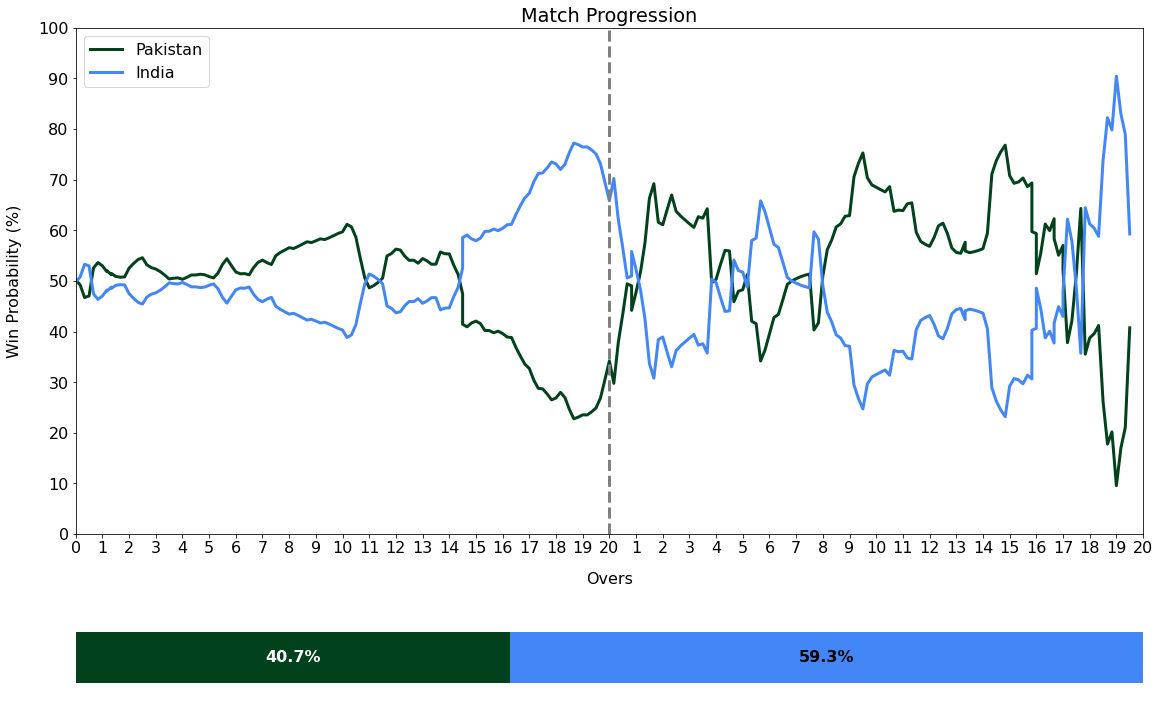

In [42]:
plot_win_prob()

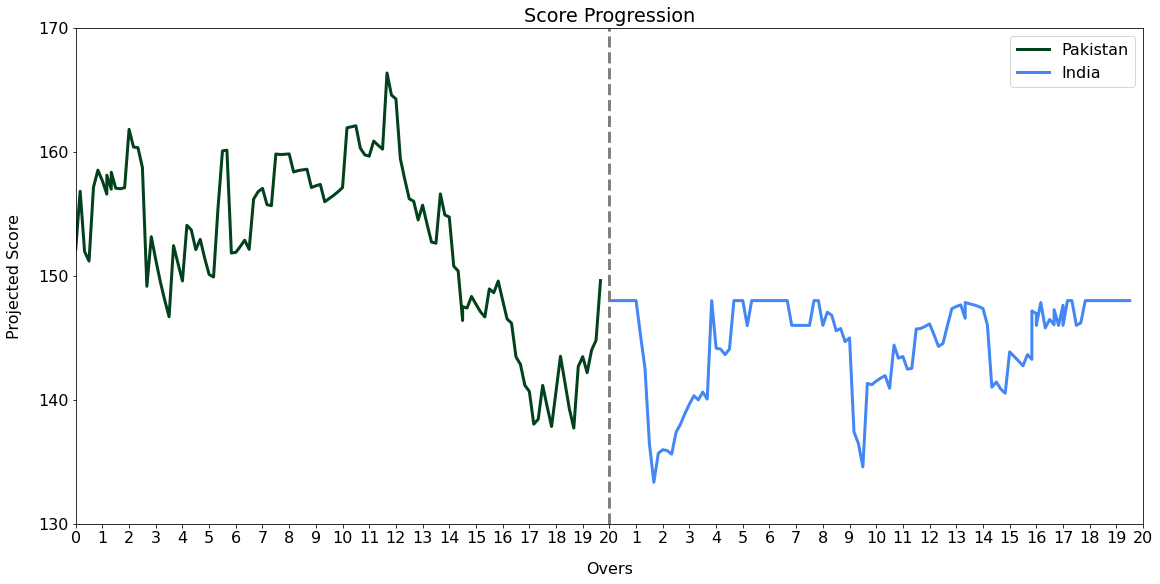

In [43]:
plot_score_prog()